In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [2]:
st = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")
data = pd.read_csv("./comments.csv")

comments = data[['textClean', 'videoId']]

text = comments["textClean"].values.tolist()

dico_font_video = {}

for i, videoid in enumerate(comments.videoId.unique()):
    dico_font_video[videoid] = i

font = [dico_font_video[videoid] for videoid in comments.videoId]

In [3]:
embs = st.encode(text)
pca = PCA(2).fit_transform(embs)

In [4]:
kmeans = KMeans(5, n_init=80, max_iter=2000).fit(embs)

In [5]:
center_indices = [
    int(np.argmin([np.sum((x-centroid)**2) for x in embs]))
    for centroid in kmeans.cluster_centers_]

commentaires_representants = [comments.textClean[i] for i in center_indices]
representants = ''
for i, comment in enumerate(commentaires_representants):
    representants += f'{i}:{comment} \n'
print(representants)

0:merci pour ton travail de recherche et de vulgarisation ❤️ 
1:un régal, comme d'hab! merci pour ce très beau travail 
2:le montage est toujours aussi bon c’est ouf 🤌🏼 
3:édifiant... 
et super vidéo comme d'habitude. trop fier de te soutenir sur teepee. merci à toi pour l'intelligence que tu dispense autour de toi. 
4:j'adore tes vidéos ! le montage est vraiment bien en plus, continue comme ça 



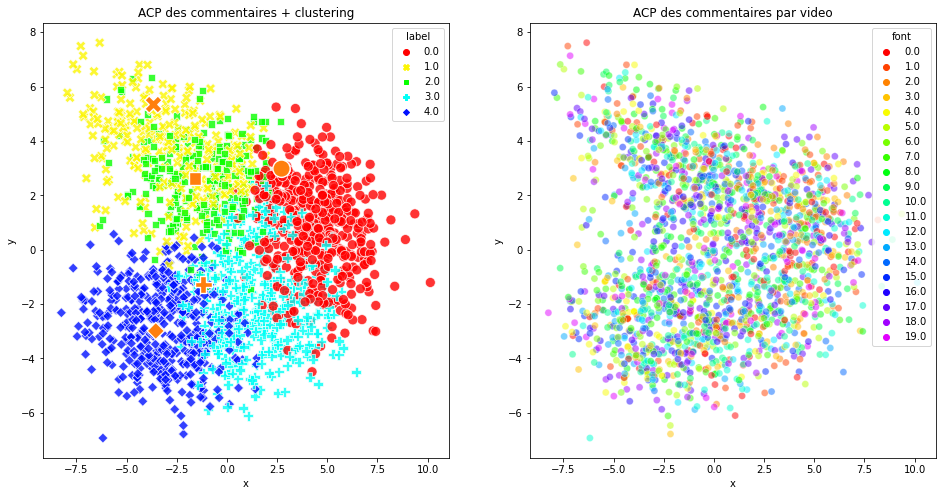

0:merci pour ton travail de recherche et de vulgarisation ❤️ 
1:un régal, comme d'hab! merci pour ce très beau travail 
2:le montage est toujours aussi bon c’est ouf 🤌🏼 
3:édifiant... 
et super vidéo comme d'habitude. trop fier de te soutenir sur teepee. merci à toi pour l'intelligence que tu dispense autour de toi. 
4:j'adore tes vidéos ! le montage est vraiment bien en plus, continue comme ça 



In [6]:
plt.subplots(figsize=(16, 8))

data = pd.DataFrame(np.array([pca[:, 0], pca[:, 1], font, kmeans.labels_]).transpose(),
                    columns=['x', 'y', 'font', 'label'])
data = data.sample(frac=1)

plt.subplot(121)
sns.scatterplot(data=data,
                x='x',
                y='y',
                hue='label',
                style='label',
                s=100,
                hue_norm=(0,6),
                alpha=.8,
                palette='hsv',
                legend='full')

sns.scatterplot(x=[pca[i, 0] for i in center_indices], 
                y=[pca[i, 1] for i in center_indices],
                style=[i for i in range(len(center_indices))],
                s=300,
                legend=False)
plt.title("ACP des commentaires + clustering")

plt.subplot(122)

sns.scatterplot(data=data,
                x='x',
                y='y',
                hue='font',
                hue_norm=(0, 23),
                s=50,
                palette='hsv',
                alpha=.5,
                legend='full')
plt.title("ACP des commentaires par video")

plt.show()
print(representants)

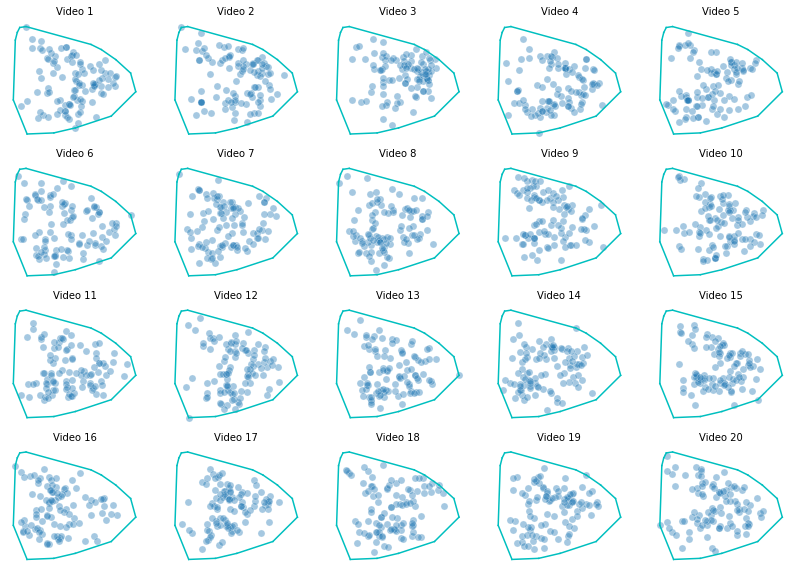

In [7]:
from scipy.spatial import ConvexHull

hull = ConvexHull(pca)

fig, axs = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(np.array(axs).flatten()):
    sns.scatterplot(x=[pca[j, 0] for j in range(len(font)) if font[j] == i],
                    y=[pca[j, 1] for j in range(len(font)) if font[j] == i],
                    s=50,
                    ax=ax,
                    alpha=0.4)
    for simplex in hull.simplices:
            ax.plot(pca[simplex, 0], pca[simplex, 1], 'c')
    ax.set_title(f'Video {i+1}', fontsize=10)
    ax.axis('off')
plt.show()

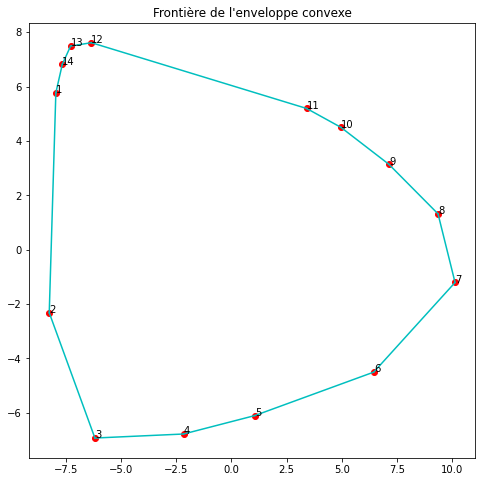

1 : c'était passionnant, merci pour ton travail !
 2 : merci pour cette vidéo très enrichissante!
 3 : tes vidéos sont vraiment incroyable !
 4 : je tenais à dire que tu as probablement le meilleur monteur vidéo du monde, tes vidéos me font rire à chaque fois, et apprendre beaucoup de choses intéressantes, un grand bravo !
 5 : je regarde cette chaîne sérieusement depuis des années et je pense ne pas me tromper en disant que cette vidéo est la plus ''mindblowing'' de toutes
 6 : mais bordel pourquoi je regarde systématiquement tes vidéos en mangeant je suis si idiot . _.'
 7 : un jour je préparais un quiz pour des enfants, et j'ai hésité à intégrer les virus dans les "formes de vie". j'avais été frappé par ce désaccord des biologistes. peux-tu nous en parler ou en as-tu déjà parlé ? 🙂
 8 : birdy biology au beau milieu de son trajet: "merde! j'ai pensé à éteindre le four ou pas?"
 9 : dirtybiology : le rose n'existe pas 

moi : regarde toulouse s'enfoncer dans un vortex spatio-temporel


In [8]:
plt.figure(figsize=(8,8))
for simplex in hull.simplices:
    plt.plot(pca[simplex, 0], pca[simplex, 1], 'c')
bound = np.array([pca[i] for i in hull.vertices])
plt.scatter(x=bound[:, 0], y=bound[:, 1], color='r')
for name, vect in zip(range(len(bound)), bound):
    plt.annotate(name + 1, vect)

plt.title("Frontière de l'enveloppe convexe")
plt.show()
print(*[f'{i+1} : ' + text[ind]+'\n' for i, ind in enumerate(hull.vertices)])

In [9]:
def find_remerciement(string):
    return ('merci' in string) or ('thank' in string) or ('thx' in string)
data = data.sort_index() # On remet les commentaire dans l'ordre de leurs indices
remerciements =  data.iloc[[i for i in range(len(data)) if find_remerciement(text[i])]]
remerciements

,x,y,font,label
2,-0.326855,4.899599,0.0,1.0
7,-1.169387,-2.257461,0.0,3.0
10,-0.419528,-4.401023,0.0,3.0
12,-4.726873,-1.303732,0.0,4.0
15,-0.326855,4.899600,0.0,1.0
...,...,...,...,...
1985,-4.582444,-1.705799,19.0,4.0
1986,-7.165160,4.976793,19.0,1.0
1990,-0.081617,2.735014,19.0,1.0
1993,-1.879110,3.072150,19.0,1.0


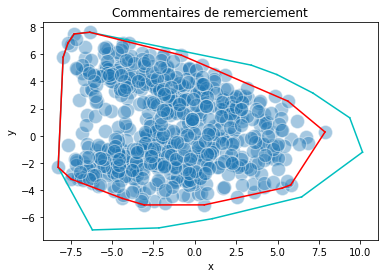

In [10]:
pca_remerciements = np.array(remerciements[['x','y']])
hull_remerciements = ConvexHull(pca_remerciements)

sns.scatterplot(data=remerciements,
                x='x',
                y='y',
                s=200,
                alpha=.4,
                legend='full')
for simplex in hull.simplices:
    plt.plot(pca[simplex, 0], pca[simplex, 1], 'c')
for simplex in hull_remerciements.simplices:
    plt.plot(pca_remerciements[simplex, 0], pca_remerciements[simplex, 1], 'r')
plt.title("Commentaires de remerciement")
plt.show()